In [1]:
import json
import numpy as np
import pandas as pd
import csv
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.base import clone
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score, auc, roc_curve, roc_auc_score
from keras.models import model_from_json

sns.set_style("darkgrid")

In [2]:
data = pd.read_pickle("synergy_carry_value_df_encoded.pkl")
data_train, data_test = train_test_split(data,shuffle=True,random_state=6453,test_size=.2)

In [3]:
model = Sequential()
model.add(Dense(70, input_dim=len(list(data.columns)[:-5]), activation="relu"))
model.add(Dense(25, activation="relu"))
model.add(Dense(2, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
model.fit(np.asarray(data_train[list(data.columns)[:-5]].values).astype('float32'), np.asarray(data_train["Top 4"]).astype('int'), validation_split = .2, epochs=200, batch_size=10000)

Epoch 1/100
10/10 [==============================] - 0s 30ms/step - loss: 0.7905 - accuracy: 0.5098 - val_loss: 0.7193 - val_accuracy: 0.5188
Epoch 2/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6522 - accuracy: 0.6104 - val_loss: 0.6176 - val_accuracy: 0.6766
Epoch 3/100
10/10 [==============================] - 0s 12ms/step - loss: 0.5890 - accuracy: 0.6984 - val_loss: 0.5608 - val_accuracy: 0.7117
Epoch 4/100
10/10 [==============================] - 0s 12ms/step - loss: 0.5431 - accuracy: 0.7289 - val_loss: 0.5289 - val_accuracy: 0.7413
Epoch 5/100
10/10 [==============================] - 0s 12ms/step - loss: 0.5158 - accuracy: 0.7513 - val_loss: 0.5070 - val_accuracy: 0.7555
Epoch 6/100
10/10 [==============================] - 0s 13ms/step - loss: 0.4960 - accuracy: 0.7624 - val_loss: 0.4903 - val_accuracy: 0.7653
Epoch 7/100
10/10 [==============================] - 0s 13ms/step - loss: 0.4811 - accuracy: 0.7710 - val_loss: 0.4773 - val_accuracy: 0.7726
Epoch 

10/10 [==============================] - 0s 12ms/step - loss: 0.4021 - accuracy: 0.8114 - val_loss: 0.4172 - val_accuracy: 0.8068
Epoch 59/100
10/10 [==============================] - 0s 12ms/step - loss: 0.4022 - accuracy: 0.8119 - val_loss: 0.4178 - val_accuracy: 0.8055
Epoch 60/100
10/10 [==============================] - 0s 12ms/step - loss: 0.4030 - accuracy: 0.8113 - val_loss: 0.4189 - val_accuracy: 0.8047
Epoch 61/100
10/10 [==============================] - 0s 12ms/step - loss: 0.4019 - accuracy: 0.8117 - val_loss: 0.4168 - val_accuracy: 0.8064
Epoch 62/100
10/10 [==============================] - 0s 12ms/step - loss: 0.4008 - accuracy: 0.8123 - val_loss: 0.4188 - val_accuracy: 0.8044
Epoch 63/100
10/10 [==============================] - 0s 12ms/step - loss: 0.4006 - accuracy: 0.8125 - val_loss: 0.4217 - val_accuracy: 0.8042
Epoch 64/100
10/10 [==============================] - 0s 12ms/step - loss: 0.4010 - accuracy: 0.8123 - val_loss: 0.4163 - val_accuracy: 0.8074
Epoch 65/100

In [4]:
prob = model.predict(np.asarray(data_train[list(data.columns)[:-5]].values).astype('float32'))
print(roc_auc_score(np.asarray(data_train["Top 4"].values).astype('int'),prob[:,1]))

pred = [np.argmax(x) for x in prob]
print(accuracy_score(pred, np.asarray(data_train["Top 4"].values).astype('int')))

0.9010936839670813
0.8147091349603653


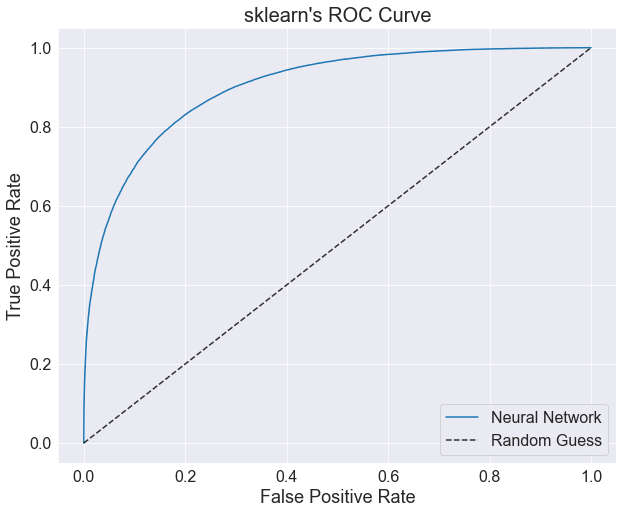

In [5]:
fprs, tprs, thresholds = roc_curve(np.asarray(data_train["Top 4"].values).astype('int'),prob[:,1])

plt.figure(figsize=(10,8))

plt.plot(fprs, tprs, label="Neural Network")
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), 'k--', alpha=.8, label="Random Guess")

plt.xlabel("False Positive Rate", fontsize=18)
plt.ylabel("True Positive Rate", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)


plt.legend(fontsize=16)

plt.title("sklearn's ROC Curve", fontsize=20)

plt.show()

Saved model to disk


### We will choose this model and will work now witht test set

In [7]:
prob = model.predict(np.asarray(data_test[list(data.columns)[:-5]].values).astype('float32'))
print(roc_auc_score(np.asarray(data_test["Top 4"].values).astype('int'),prob[:,1]))

pred = [np.argmax(x) for x in prob]
print(accuracy_score(pred, np.asarray(data_test["Top 4"].values).astype('int')))

0.8909783090549206
0.8102988350498058


The model performs slight worst on the test set as expected since we can assume that we may have overfitted a bit on the training set but this is still within margin of error since we only require an accuracy of 80%. We can focus more on traits in such analysis. Below we assume Gold synergies.

In [8]:
features = list(data_test.columns)[:22]
for i in range(len(features)):
    temp = data_test[data_test[features[i]] == 3]
    prob = model.predict(np.asarray(temp[list(temp.columns)[:-5]].values).astype('float32'))
    pred = [np.argmax(x) for x in prob]
    try:
        print("For Synergy " + features[i] + " the ROC AUC of model is:" + 
              str(roc_auc_score(np.asarray(temp["Top 4"].values).astype('int'),prob[:,1])))
        print("For Synergy " + features[i] + " the accuracy of model is:" + 
              str(accuracy_score(np.asarray(temp["Top 4"].values).astype('int'),pred)))
        print()
    except:
        print("ROC AUC of " + features[i] + " is not defined.")
        print("For Synergy " + features[i] + " the accuracy of model is:" + 
              str(accuracy_score(np.asarray(temp["Top 4"].values).astype('int'),pred)))
        print()

For Synergy Set5_Assassin the ROC AUC of model is:0.8842580356598289
For Synergy Set5_Assassin the accuracy of model is:0.8301886792452831

For Synergy Set5_Brawler the ROC AUC of model is:0.8783744230552741
For Synergy Set5_Brawler the accuracy of model is:0.8018867924528302

For Synergy Set5_Cavalier the ROC AUC of model is:0.882141978130164
For Synergy Set5_Cavalier the accuracy of model is:0.8184357541899442

For Synergy Set5_Forgotten the ROC AUC of model is:0.8585013936710936
For Synergy Set5_Forgotten the accuracy of model is:0.8149779735682819

For Synergy Set5_Ironclad the ROC AUC of model is:0.8815654666815645
For Synergy Set5_Ironclad the accuracy of model is:0.8047534429142603

For Synergy Set5_Legionnaire the ROC AUC of model is:0.8474819113116986
For Synergy Set5_Legionnaire the accuracy of model is:0.7610619469026548

ROC AUC of Set5_Nightbringer is not defined.
For Synergy Set5_Nightbringer the accuracy of model is:1.0

For Synergy Set5_Redeemed the ROC AUC of model is:

### We're going to focus on conditional probability of this model
What we will do is predicting the probability of a win given that the model predicts and win. Preferably we want this percentage to be greater than 80% or we want to find the conditions to ensure that it will be above 80%. This way assuming we are using the winning team compositions from the model then in the long run we should expect not the drop in rank.

This is due to the the following: If we play 5 top 4 team composition (according to the model which is >= 80% correct) then on average 1 of the 5 will place in bottom 4. The worst case would be having 4 place fourth and 1 place eighth which in terms of point rankings a fourth place is +10 and an eighth is -40 and so this will equal out. 

##### Underlining assumptions for strategy
Some reasonable narutal assumption for initial run would be to assume the tier of carries will be 2 or 3 since tier 1 carries are somewhat weak relative to tier 2 carries. Further analysis can be made for comparison between tier 2 champions vs the Tier 1 transition champions


In [9]:
from sklearn.metrics import confusion_matrix
traits_col = list(data.columns)[:22]

In [10]:
print("Below is the probability of a win assuming that the model predicts a win by gold/chromatic synergies")
print()
for x in traits_col:
    test = data_test[(data_test["Primary_Carry_Tier"] >= 2) & (data_test["Secondary_Carry_Tier"] >= 2) & 
                      (data_test["Third_Carry_Tier"] >= 2) & (data_test[x] >= 3)]
    predict = model.predict(np.asarray(test[list(data.columns)[:-5]].values).astype('float32'))
    predict_placement = []
    for i in range(len(predict)):
        predict_placement.append(np.argmax(predict[i]))
    try:
        tn, fp, fn, tp = confusion_matrix(np.asarray(test["Top 4"].values).astype('int'),predict_placement).ravel()
        print(x)
        print("True Positive = " + str(tp) + " False Positive = " + str(fp))
        print("True Negative = " + str(tn) + " False Negative = " + str(fn))
        print("Probability of win assuming win predicted = " + str(tp/(tp + fp)))
        print("Probability of loss assuming loss predicted = " + str(tn/(tn + fn)))
        print()
    except:
        print(x + " has an error not enough info. Accuracy is " + str(np.sum(predict_placement == np.asarray(test["Top 4"].values).astype('int'))/len(predict_placement)))
        print()

Below is the probability of a win assuming that the model predicts a win by gold/chromatic synergies

Set5_Assassin
True Positive = 327 False Positive = 32
True Negative = 51 False Negative = 36
Probability of win assuming win predicted = 0.9108635097493036
Probability of loss assuming loss predicted = 0.5862068965517241

Set5_Brawler
True Positive = 139 False Positive = 34
True Negative = 108 False Negative = 24
Probability of win assuming win predicted = 0.8034682080924855
Probability of loss assuming loss predicted = 0.8181818181818182

Set5_Cavalier
True Positive = 180 False Positive = 19
True Negative = 50 False Negative = 28
Probability of win assuming win predicted = 0.9045226130653267
Probability of loss assuming loss predicted = 0.6410256410256411

Set5_Forgotten
True Positive = 249 False Positive = 32
True Negative = 43 False Negative = 23
Probability of win assuming win predicted = 0.8861209964412812
Probability of loss assuming loss predicted = 0.6515151515151515

Set5_Iron

In [ ]:
model = Sequential()
model.add(Dense(70, input_dim=len(list(data.columns)[:-5]), activation="relu"))
model.add(Dense(25, activation="relu"))
model.add(Dense(2, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
model.fit(np.asarray(data[list(data.columns)[:-5]].values).astype('float32'), np.asarray(data["Top 4"]).astype('int'), validation_split = .2, epochs=200, batch_size=10000)
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Epoch 1/200
12/12 [==============================] - 0s 29ms/step - loss: 0.7266 - accuracy: 0.5350 - val_loss: 0.6729 - val_accuracy: 0.5785
Epoch 2/200
12/12 [==============================] - 0s 13ms/step - loss: 0.6251 - accuracy: 0.6443 - val_loss: 0.5838 - val_accuracy: 0.6972
Epoch 3/200
12/12 [==============================] - 0s 13ms/step - loss: 0.5696 - accuracy: 0.7069 - val_loss: 0.5367 - val_accuracy: 0.7377
Epoch 4/200
12/12 [==============================] - 0s 13ms/step - loss: 0.5262 - accuracy: 0.7432 - val_loss: 0.5050 - val_accuracy: 0.7570
Epoch 5/200
12/12 [==============================] - 0s 13ms/step - loss: 0.4999 - accuracy: 0.7612 - val_loss: 0.4851 - val_accuracy: 0.7696
Epoch 6/200
12/12 [==============================] - 0s 13ms/step - loss: 0.4822 - accuracy: 0.7710 - val_loss: 0.4718 - val_accuracy: 0.7781
Epoch 7/200
12/12 [==============================] - 0s 14ms/step - loss: 0.4699 - accuracy: 0.7787 - val_loss: 0.4614 - val_accuracy: 0.7833
Epoch 

12/12 [==============================] - 0s 13ms/step - loss: 0.4029 - accuracy: 0.8119 - val_loss: 0.4136 - val_accuracy: 0.8100
Epoch 59/200
12/12 [==============================] - 0s 13ms/step - loss: 0.4023 - accuracy: 0.8121 - val_loss: 0.4140 - val_accuracy: 0.8097
Epoch 60/200
 9/12 [=====================>........] - ETA: 0s - loss: 0.4010 - accuracy: 0.8118